In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import pandas as pd
from time import time

In [2]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [3]:
from GetAgentData import *

In [4]:
#overview of the data
#dataDirectory = os.path.join(os.getcwd(),'data')
dataDirectory = r"E:\TopoptGAfileSaves\ComplianceMinimization\Agents"
DATA_FILE_PATH = os.path.join(dataDirectory,'100_50')

dir_list = os.listdir(DATA_FILE_PATH)
max_data_points = len(dir_list)
print("Number of data points: {}".format(len(dir_list)))
print(dir_list[0])

data_x_columns = ['forces','supports','filled','x']
data_y_columns = ['x','finished']


Number of data points: 3129
Agent1_485135


The sequence class will hold each problem statement as a sequence of all the iterations.
It will hold the load conditions as well as each iteration.
<ol>
<li>When training the model, some fraction of the sequences will be called and the model will train on them.</li>
<li>The model will then be given some other fraction of seqences to predict.</li>
<li>These predictions will be maped to their original inputs and will be re-outputed as new problem statment iterations.</li>
<li>The new(Model predicted) datapoints can then be inputed back into the model for training.</li>
</ol>

In [5]:
class TopOptSequence:
    def __init__(self,ID,forces,dof,passive,x,numIterations):
        self.ID = ID
        self.forceImage = forces
        self.anchorImage = dof
        self.filledAreaImage = passive
        self.xPhys_array = x
        self.numIterations = numIterations
        self.iterationJumpTracker = []
    
    def dispenceData(self,iterationJump:int=5):
        """
        When called creates list of numpy arrays filled with the data needed to train the model

        returns:
            forces_array
            support_array
            filled_array
            x_array
            x_optimized_array
            finished_array
        """
        dataX = []
        dataY = []
        self.iterationJumpTracker = []
        for j in range(self.numIterations-iterationJump):
                dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,j]])
                v = 0.0
                f= 'unfinished'
                if(j+iterationJump >= self.numIterations - 1):
                    v = 1.0
                    f = 'finished'
                dataY.append([self.xPhys_array[:,:,j+iterationJump],np.array([v])])
                self.iterationJumpTracker.append([j,j+iterationJump])

                #print("Adding itter: {} -> {}:{}".format(j,j+iterationJump,f))

        for j in range(1,min(iterationJump,self.numIterations)):
            # add the last iterations(dataY has True)
            dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,-j -1]])
            dataY.append([self.xPhys_array[:,:,self.numIterations-1],np.array([1.])])
            self.iterationJumpTracker.append([-j,self.numIterations-1])

            #print("Adding itter: {} -> {}:finished".format(numIterations-j-1,numIterations-1))

        # add the optimal Stoping point data, input = output
        dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,self.numIterations-1]])
        dataY.append([self.xPhys_array[:,:,self.numIterations-1],np.array([1.])])
        self.iterationJumpTracker.append([self.numIterations-1,self.numIterations-1])


        forces_array = []
        support_array = []
        filled_array = []
        x_array = []
        for forces,support,filled,x in dataX:

            forces_array.append(forces)
            support_array.append(support)
            filled_array.append(filled)
            x_array.append(x)

        x_optimized_array = []
        finished_array = []
        for x,finished in dataY:
            x_optimized_array.append(x)
            finished_array.append(finished)


        return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array

    def findNextIterations(self,i):
        """
        Given and index for a predicted image, find it's next optimized output.
        each output image will have a order that matches the order of it's input.
        By knowing the input image we can find what image the prediction was supposed to be.
        By knowing what the image was supposed to be, we can find next step in the iteration.


        Process works like this:
            - iterationTracker stores the input and output image,
            - We know the input image so we use this to find the correct output image
            - We then search the tracker for where the output image was used as input to get the correct next iteration.
        """
        def searchTracker(index):
            """given an input index find the matching output index"""
            for inputIndex,outputIndex in self.iterationJumpTracker:
                if(inputIndex == index):
                    return outputIndex
            return -1
        
        correctOutput = searchTracker(i)
        nextIteration = searchTracker(correctOutput)
        return nextIteration

    def formatPredictedData(self,predicted_x_array):
        """
        Given an array of images and the finished array, reformate the images with their respective inputs to create a new dataset that has as input the predicted x and as output the correct next iteration.

        The iteration Jump tracker has stored what iterations were jumped so by following the tracker list we can find the correct next output
        """

        n = len(predicted_x_array)
        if(n ==  self.numIterations):#check if correct number of iterations has been recieved
            forces_array = []
            support_array = []
            filled_array = []
            x_array = []
            x_optimized_array = []
            finished_array = []
            for i in range(n):
                correctOutput = self.findNextIterations(i)
                if(correctOutput <= 0):
                    continue
                else:
                    forces_array.append(self.forceImage.copy())
                    support_array.append(self.anchorImage.copy())
                    filled_array.append(self.filledAreaImage.copy())

                    x_array.append(predicted_x_array[i].copy())
                    v = 0.0
                    if(correctOutput >= n):
                        correctOutput = n-1
                        v = 1.0
                    x_optimized_array.append(self.xPhys_array[:,:,correctOutput])
                    finished_array.append([v])
                    
            return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array

        else:
            raise Exception("Data given is not of the correct format. required iterations: {}. iterations recieved: {}".format(self.numIterations,n))

    def dispenceFirstIterationData(self):
        dataX = []
        dataY = []
        
        dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,0]])
        dataY.append([self.xPhys_array[:,:,1],np.array([0])])

        dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,0]])
        dataY.append([self.xPhys_array[:,:,2],np.array([0])])

        forces_array = []
        support_array = []
        filled_array = []
        x_array = []
        for forces,support,filled,x in dataX:

            forces_array.append(forces)
            support_array.append(support)
            filled_array.append(filled)
            x_array.append(x)

        x_optimized_array = []
        finished_array = []
        for x,finished in dataY:
            x_optimized_array.append(x)
            finished_array.append(finished)


        return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array
        
    def dispenceM7modelData(self,iterationJump:int=5,predictionDepth:int=5):
        """
        When called creates list of numpy arrays filled with the data needed to train the model
        Designed to return the inital input but with an array of output representing the folowing iterations.

        This will allow the model to train on its own predictions
        """
        dataX = []
        dataY = []
        for j in range(self.numIterations-(iterationJump//2)):
            dataX.append([self.forceImage.copy(),self.anchorImage.copy(),self.filledAreaImage.copy(),self.xPhys_array[:,:,j]])
            
            dataY.append([])
            for i in range(predictionDepth):
                currentIteration = min(j + i*iterationJump,self.numIterations-1)
                v = 0.0
                if(currentIteration >= self.numIterations - 1):
                    v = 1.0
                dataY[j].append([self.xPhys_array[:,:,currentIteration],np.array([v])])


        forces_array = []
        support_array = []
        filled_array = []
        x_array = []
        for forces,support,filled,x in dataX:

            forces_array.append(forces)
            support_array.append(support)
            filled_array.append(filled)
            x_array.append(x)

        x_optimized_array = []
        finished_array = []
        for i in range(len(dataY)):
            x_optimized_array.append([])
            finished_array.append([])
            for x,finished in dataY[i]:
                x_optimized_array[i].append(x)
                finished_array[i].append(finished)


        return forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array


In [6]:
def buildDataSet(dataPointsToGrab:int):

    # Constants of interest
    # DATA_FILE_PATH = path to agent files
    # dir_List = all agent files
    # max_data_points = total number of datapoints

    dataPointsToGrab = min(dataPointsToGrab,max_data_points)

    #randomize the data grabed so that the first thee datapoints aren't always in the data.
    indexList = np.arange(max_data_points,dtype='int32')
    np.random.shuffle(indexList)

    sequenceData = []
    print("Retreiving {} Datapoints.".format(dataPointsToGrab))

    for i in range(dataPointsToGrab):
        print("{:.2f}%\t\t".format((100*(i/dataPointsToGrab))),end='\r')
        try:
            #join the data file path to a random sorted member within the data directory
            pathToAgent = os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])
            forces,dof,passive,x,numIterations = formatIterativeModelDataSet(pathToAgent)
        except:
            #if an exception occurs list it and move forward
            print("Exception Occured at file '{}'.".format(os.path.join(DATA_FILE_PATH,dir_list[indexList[i]])))
            continue
        else:
            #if no error occured append that data to the data list
            sequenceData.append(TopOptSequence(i,forces,dof,passive,x,numIterations))

    print("100%\t\t")
    return sequenceData
        


In [7]:
Data = buildDataSet(50)
print(len(Data))

Retreiving 50 Datapoints.
100%				
50


In [8]:
#check if the data output is correct
def checkArrays(arraysOfValues):
    correct = True
    for i in range(1,len(arraysOfValues)):
        a = np.equal(arraysOfValues[i-1],arraysOfValues[i]).sum()
        numberofValues = np.prod(arraysOfValues[i-1].shape)
        #print(a,numberofValues)
        if(a != numberofValues):
            print("iteration {} is not the same as iteration {}, {} != {}.".format(i-1,i,a,numberofValues))
            correct = False
        #print(a,forceValues)

    return correct
            
def plotIteration(input_array,output_array,finished_array):
    numIterations = len(input_array)
    for i in range(numIterations):
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(input_array[i].T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[0].set_title("Input")

        ax[1].imshow(output_array[i].T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax[1].get_xaxis().set_visible(False)
        ax[1].get_yaxis().set_visible(False)
        ax[1].set_title("Output, Finished:{}".format(finished_array[i]))
        
        plt.show()



def checkData(indexToUse):
    currentSum = 0
    for sequence in Data:
        currentSum += sequence.numIterations
    
    print("With {} problem statements there are {} sample datapoints.".format(len(Data),currentSum))

    forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array = Data[indexToUse].dispenceFirstIterationData()
    #check forces
    print("check Forces:")
    if(checkArrays(forces_array)):
        print("\tOk.")

    print("check Supports:")
    if(checkArrays(support_array)):
        print("\tOk.")
    
    print("check Filled area:")
    if(checkArrays(filled_array)):
        print("\tOk.")
    
    numIterations = Data[indexToUse].numIterations
    print("Iterations:",numIterations )
    plotIteration(x_array,x_optimized_array,finished_array)


With 50 problem statements there are 923 sample datapoints.
check Forces:
	Ok.
check Supports:
	Ok.
check Filled area:
	Ok.
Iterations: 9


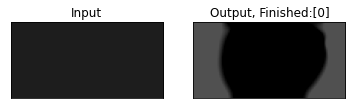

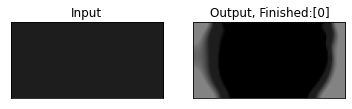

In [9]:
#forces_array,support_array,filled_array,x_array,x_optimized_array,finished_array = Data[0].dispenceData()

#print(Data[0].numIterations)
#print(len(x_array))
checkData(0)

In [10]:
#Test Train Split
"""
By performing the test train split we can get a training data set and a testing dataset to get the metrics for out model
By performing the split a second time we can get a validataion dataset that the model will never see that we can use to get out own accuracy score out of
"""
Data_train, Data_test = train_test_split(Data, test_size=0.85)
Data_test, Data_score= train_test_split(Data_test, test_size=0.7)
print("Train: {}".format(len(Data_train)))
print("\nTest: {}".format(len(Data_test)))
print("\nScore: {}".format(len(Data_score)))

Train: 7

Test: 12

Score: 31


<h1>Model Information</h1>

Below are the models that will be used to attempt to learn the dataset

In [11]:
#universal parameters
activation = 'relu'
uniformRandomInitalizer = tf.random_uniform_initializer(minval=-0.5, maxval=0.5)

In [12]:
def unet_model_m4(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    """
    A U-net architecture model to be used to predict the first iteration of the part.
    all input images are upscalled to the nearest power of two
    """
    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")


    partInput_resize = layers.Resizing(height=128,width=64)(partInput)
    forcesInput_resize = layers.Resizing(height=128,width=64)(forcesInput)
    supportsInput_resize = layers.Resizing(height=128,width=64)(supportsInput)
    filledInput_resize = layers.Resizing(height=128,width=64)(filledInput)

    
    concatenatedConvolution = layers.Concatenate()([partInput_resize,forcesInput_resize,supportsInput_resize,filledInput_resize])

    convolution1 = layers.Conv2D(filters= 32, kernel_size=(3,3),strides=1,padding='same',activation=activation)(concatenatedConvolution)
    convolution1 = layers.Conv2D(filters= 32, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution1)

    convolution2 = layers.MaxPool2D(pool_size=(2,2))(convolution1)
    convolution2 = layers.Conv2D(filters= 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution2)
    convolution2 = layers.Conv2D(filters= 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution2)

    convolution3 = layers.MaxPool2D(pool_size=(2,2))(convolution2)
    convolution3 = layers.Conv2D(filters= 128, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution3)
    convolution3 = layers.Conv2D(filters= 128, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution3)
    
    convolution4 = layers.Conv2DTranspose(filters=64, kernel_size=(3,3),strides=2,padding='same',activation=activation)(convolution3)
    convolution4 = layers.Concatenate()([convolution4,convolution2])
    convolution4 = layers.Conv2D(filters= 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution4)
    convolution4 = layers.Conv2D(filters= 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution4)

    convolution5 = layers.Conv2DTranspose(filters=32, kernel_size=(3,3),strides=2,padding='same',activation=activation)(convolution4)
    convolution5 = layers.Concatenate()([convolution5,convolution1])
    convolution5 = layers.Conv2D(filters= 32, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution5)
    convolution5 = layers.Conv2D(filters= 32, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convolution5)

    outputConvolution = layers.Resizing(height=100,width=50)(convolution5)
    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1),strides=1,padding='same',activation=activation, name="x_out")(outputConvolution)

    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part])



In [13]:
def model_m5(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    """
    Modle based off the m3 but with noise reduction embedded into it.
    """

    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")

    partInput_resize = layers.Resizing(height=128,width=64)(partInput)
    forcesInput_resize = layers.Resizing(height=128,width=64)(forcesInput)
    forcesInput_resize = layers.Activation(activation='tanh')(forcesInput_resize)# normaize the force input
    supportsInput_resize = layers.Resizing(height=128,width=64)(supportsInput)
    filledInput_resize = layers.Resizing(height=128,width=64)(filledInput)

    concatenatedStartLayer = layers.Concatenate()([partInput_resize,forcesInput_resize,supportsInput_resize,filledInput_resize])

    #First Convolution Layer
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(concatenatedStartLayer)
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(conv_128_64)
    conv_64_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_128_64)
    conv_64_32 = layers.Dropout(rate=0.1)(conv_64_32)

    #Second convolution Layer
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_32_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_64_32)
    conv_32_16 = layers.Dropout(rate=0.2)(conv_32_16)

    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_16_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_32_16)
    conv_16_8 = layers.Dropout(rate=0.3)(conv_16_8)

    conv_16_8 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)
    conv_16_8 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)

    #Dense 2D layer
    newShape=conv_16_8.shape[1:]
    shapeFlat = np.prod(newShape)
    print("x2.Shape:{}={}".format(newShape,shapeFlat))
    denseLayer = layers.Flatten()(conv_16_8)
    denseLayer = layers.Dense(shapeFlat,activation=activation)(denseLayer)
    denseLayer = layers.Reshape(newShape)(denseLayer)

    #upscaleLayer
    #upscaling is performed by convolution transpose where stride=2 < kernalsize
    convUpscale_32_16 = layers.Conv2DTranspose(filters= 32, kernel_size=(5,5),strides=2,padding='same',activation=activation)(denseLayer)
    print("32_16:",convUpscale_32_16.shape)
    convUpscale_32_16 = layers.Dropout(rate=0.3)(convUpscale_32_16)
    convUpscale_32_16 = layers.Concatenate()([convUpscale_32_16,conv_32_16])
    convUpscale_32_16 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_32_16)

    convUpscale_64_32 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_32_16)
    print("64_32:",convUpscale_32_16.shape)
    convUpscale_64_32 = layers.Dropout(rate=0.2)(convUpscale_64_32)
    convUpscale_64_32 = layers.Concatenate()([convUpscale_64_32,conv_64_32])
    convUpscale_64_32 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_64_32)

    convUpscale_128_64 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_64_32)
    print("128_64:",convUpscale_32_16.shape)
    convUpscale_128_64 = layers.Dropout(rate=0.1)(convUpscale_128_64)
    convUpscale_128_64 = layers.Concatenate()([convUpscale_128_64,conv_128_64])
    convUpscale_128_64 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_128_64)

    output_resize =layers.Resizing(height=100,width=50)(convUpscale_128_64)
    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1),padding='same',activation='sigmoid', name="x_out")(output_resize)



    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part])

# m = model_m5()
# m.summary()

In [14]:
def model_m6(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    """
    Modle based off the m3 but with noise reduction embedded into it.
    """

    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")

    partInput_resize = layers.Resizing(height=128,width=64)(partInput)
    forcesInput_resize = layers.Resizing(height=128,width=64)(forcesInput)
    forcesInput_resize = layers.Activation(activation='tanh')(forcesInput_resize)# normaize the force input
    supportsInput_resize = layers.Resizing(height=128,width=64)(supportsInput)
    filledInput_resize = layers.Resizing(height=128,width=64)(filledInput)

    concatenatedStartLayer = layers.Concatenate()([partInput_resize,forcesInput_resize,supportsInput_resize,filledInput_resize])

    #First Convolution Layer
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(concatenatedStartLayer)
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(conv_128_64)
    conv_64_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_128_64)
    conv_64_32 = layers.GaussianNoise(stddev=0.1)(conv_64_32)
    conv_64_32 = layers.Dropout(rate=0.1)(conv_64_32)

    #Second convolution Layer
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_32_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_64_32)
    conv_32_16 = layers.GaussianNoise(stddev=0.1)(conv_32_16)
    conv_32_16 = layers.Dropout(rate=0.2)(conv_32_16)

    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_16_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_32_16)
    conv_16_8 = layers.Dropout(rate=0.3)(conv_16_8)

    conv_16_8 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)
    conv_16_8 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)

    #Dense 2D layer
    newShape=conv_16_8.shape[1:]
    shapeFlat = np.prod(newShape)
    #print("x2.Shape:{}={}".format(newShape,shapeFlat))
    denseLayer = layers.Flatten()(conv_16_8)
    denseLayer = layers.Dense(shapeFlat,activation=activation)(denseLayer)
    denseLayer_16_8 = layers.Reshape(newShape)(denseLayer)

    #upscaleLayer
    #upscaling is performed by convolution transpose where stride=2 < kernalsize
    convUpscale_32_16 = layers.Conv2DTranspose(filters= 32, kernel_size=(5,5),strides=2,padding='same',activation=activation)(denseLayer_16_8)
    #print("32_16:",convUpscale_32_16.shape)
    convUpscale_32_16 = layers.Dropout(rate=0.3)(convUpscale_32_16)
    convUpscale_32_16 = layers.GaussianNoise(stddev=0.1)(convUpscale_32_16)
    convUpscale_32_16 = layers.Concatenate()([convUpscale_32_16,conv_32_16])
    convUpscale_32_16 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_32_16)

    convUpscale_64_32 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_32_16)
    #print("64_32:",convUpscale_32_16.shape)
    convUpscale_64_32 = layers.Dropout(rate=0.2)(convUpscale_64_32)
    convUpscale_64_32 = layers.GaussianNoise(stddev=0.1)(convUpscale_64_32)
    convUpscale_64_32 = layers.Concatenate()([convUpscale_64_32,conv_64_32])
    convUpscale_64_32 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_64_32)

    convUpscale_128_64 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_64_32)
    #print("128_64:",convUpscale_32_16.shape)
    convUpscale_128_64 = layers.Dropout(rate=0.1)(convUpscale_128_64)
    convUpscale_128_64 = layers.Concatenate()([convUpscale_128_64,conv_128_64])
    convUpscale_128_64 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_128_64)

    output_resize =layers.Resizing(height=100,width=50)(convUpscale_128_64)
    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1),padding='same',activation='hard_sigmoid', name="x_out")(output_resize)
    """
    The hard sigmoid activation, defined as:
        if x < -2.5: return 0
        if x > 2.5: return 1
        if -2.5 <= x <= 2.5: return 0.2 * x + 0.5
    """
    finishedCheckLayer = layers.Dense(10)(denseLayer)
    finishedCheckLayer = layers.Dense(10)(finishedCheckLayer)
    finishedOutput = layers.Dense(1,name='finished')(finishedCheckLayer)




    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part,finishedOutput])

# m = model_m5()
# m.summary()

In [15]:
def buildModel_m7(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")

    partInput_resize = layers.Resizing(height=128,width=64)(partInput)
    forcesInput_resize = layers.Resizing(height=128,width=64)(forcesInput)
    forcesInput_resize = layers.Activation(activation='tanh')(forcesInput_resize)# normaize the force input
    supportsInput_resize = layers.Resizing(height=128,width=64)(supportsInput)
    filledInput_resize = layers.Resizing(height=128,width=64)(filledInput)

    concatenatedStartLayer = layers.Concatenate()([partInput_resize,forcesInput_resize,supportsInput_resize,filledInput_resize])

    #First Convolution Layer
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(concatenatedStartLayer)
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(conv_128_64)
    conv_64_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_128_64)
    conv_64_32 = layers.GaussianNoise(stddev=0.1)(conv_64_32)
    conv_64_32 = layers.Dropout(rate=0.1)(conv_64_32)

    #Second convolution Layer
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_32_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_64_32)
    conv_32_16 = layers.GaussianNoise(stddev=0.1)(conv_32_16)
    conv_32_16 = layers.Dropout(rate=0.2)(conv_32_16)

    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_16_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_32_16)
    conv_16_8 = layers.Dropout(rate=0.3)(conv_16_8)

    conv_16_8 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)
    conv_16_8 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)

    #Dense 2D layer
    newShape=conv_16_8.shape[1:]
    shapeFlat = np.prod(newShape)
    denseLayer = layers.Flatten()(conv_16_8)
    denseLayer = layers.Dense(shapeFlat,activation=activation)(denseLayer)
    denseLayer_16_8 = layers.Reshape(newShape)(denseLayer)

    #upscaleLayer
    #upscaling is performed by convolution transpose where stride=2 < kernalsize
    convUpscale_32_16 = layers.Conv2DTranspose(filters= 32, kernel_size=(5,5),strides=2,padding='same',activation=activation)(denseLayer_16_8)
    convUpscale_32_16 = layers.Dropout(rate=0.3)(convUpscale_32_16)
    convUpscale_32_16 = layers.GaussianNoise(stddev=0.1)(convUpscale_32_16)
    convUpscale_32_16 = layers.Concatenate()([convUpscale_32_16,conv_32_16])
    convUpscale_32_16 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_32_16)

    convUpscale_64_32 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_32_16)
    convUpscale_64_32 = layers.Dropout(rate=0.2)(convUpscale_64_32)
    convUpscale_64_32 = layers.GaussianNoise(stddev=0.1)(convUpscale_64_32)
    convUpscale_64_32 = layers.Concatenate()([convUpscale_64_32,conv_64_32])
    convUpscale_64_32 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_64_32)

    convUpscale_128_64 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_64_32)
    convUpscale_128_64 = layers.Dropout(rate=0.1)(convUpscale_128_64)
    convUpscale_128_64 = layers.Concatenate()([convUpscale_128_64,conv_128_64])
    convUpscale_128_64 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_128_64)

    output_resize =layers.Resizing(height=100,width=50)(convUpscale_128_64)
    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1),padding='same',activation='hard_sigmoid', name="x_out")(output_resize)
    """
    The hard sigmoid activation, defined as:
        if x < -2.5: return 0
        if x > 2.5: return 1
        if -2.5 <= x <= 2.5: return 0.2 * x + 0.5
    """

    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part])#,finishedOutput])

class Model_m7(keras.Model):
    def __init__(self):

        super(Model_m7, self).__init__()
        self.model = buildModel_m7()
        

    def call(self,data,training = False):
        #part = data['x']
        #forces = data['forces']
        #supports = data['supports']
        #filled = data['filled']
        #print(1)
        if(training):
            
            out1 = self.model(data)
            data['x'] = out1
            
            #print(2)
            out2 = self.model(data)
            data['x'] = out2

            out3 = self.model(data)
            data['x'] = out3
        
            out4 = self.model(data)
            data['x'] = out4

            out5 = self.model(data)
            #print(6)
            return out1,out2,out3,out4,out5
        else:
            return self.model(data)







In [16]:
def buildModel_m8(x_inputShape = (100,50,1),forces_inputShape = (101,51,2),supports_inputShape = (101,51,1),filled_inputShape = (100,50,1)):
    partInput = keras.Input(shape=x_inputShape,name="x")
    forcesInput = keras.Input(shape=forces_inputShape,name="forces")
    supportsInput = keras.Input(shape=supports_inputShape,name="supports")
    #since filled input is solely the solid area it will be passed into the model at the very end
    filledInput = keras.Input(shape=filled_inputShape,name="filled")

    partInput_resize = layers.Resizing(height=128,width=64)(partInput)
    forcesInput_resize = layers.Resizing(height=128,width=64)(forcesInput)
    forcesInput_resize = layers.Activation(activation='tanh')(forcesInput_resize)# normaize the force input
    supportsInput_resize = layers.Resizing(height=128,width=64)(supportsInput)
    filledInput_resize = layers.Resizing(height=128,width=64)(filledInput)

    concatenatedStartLayer = layers.Concatenate()([partInput_resize,forcesInput_resize,supportsInput_resize,filledInput_resize])

    #First Convolution Layer
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(concatenatedStartLayer)
    conv_128_64 = layers.Conv2D(filters= 16, kernel_size=(3,3),padding='same',activation=activation)(conv_128_64)
    conv_64_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_128_64)
    conv_64_32 = layers.GaussianNoise(stddev=0.1)(conv_64_32)

    #Second convolution Layer
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_64_32 = layers.Conv2D(filters= 32, kernel_size=(3,3),padding='same',activation=activation)(conv_64_32)
    conv_32_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_64_32)
    conv_32_16 = layers.GaussianNoise(stddev=0.1)(conv_32_16)

    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_32_16 = layers.Conv2D(filters= 64, kernel_size=(3,3),padding='same',activation=activation)(conv_32_16)
    conv_16_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_32_16)
    conv_16_8 = layers.GaussianNoise(stddev=0.1)(conv_16_8)

    conv_16_8 = layers.Conv2D(filters= 128, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)
    conv_16_8 = layers.Conv2D(filters= 128, kernel_size=(3,3),padding='same',activation=activation)(conv_16_8)

    #upscaleLayer
    #upscaling is performed by convolution transpose where stride=2 < kernalsize
    convUpscale_32_16 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(conv_16_8)
    convUpscale_32_16 = layers.GaussianNoise(stddev=0.1)(convUpscale_32_16)
    convUpscale_32_16 = layers.Concatenate()([convUpscale_32_16,conv_32_16])
    convUpscale_32_16 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_32_16)
    convUpscale_32_16 = layers.Conv2D(filters = 64, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_32_16)

    convUpscale_64_32 = layers.Conv2DTranspose(filters= 32, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_32_16)
    convUpscale_64_32 = layers.GaussianNoise(stddev=0.1)(convUpscale_64_32)
    convUpscale_64_32 = layers.Concatenate()([convUpscale_64_32,conv_64_32])
    convUpscale_64_32 = layers.Conv2D(filters = 32, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_64_32)
    convUpscale_64_32 = layers.Conv2D(filters = 32, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_64_32)

    convUpscale_128_64 = layers.Conv2DTranspose(filters= 64, kernel_size=(5,5),strides=2,padding='same',activation=activation)(convUpscale_64_32)
    convUpscale_64_32 = layers.GaussianNoise(stddev=0.1)(convUpscale_64_32)
    convUpscale_128_64 = layers.Concatenate()([convUpscale_128_64,conv_128_64])
    convUpscale_128_64 = layers.Conv2D(filters = 16, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_128_64)
    convUpscale_128_64 = layers.Conv2D(filters = 16, kernel_size=(3,3),strides=1,padding='same',activation=activation)(convUpscale_128_64)

    output_resize =layers.Resizing(height=100,width=50)(convUpscale_128_64)
    output_part = layers.Conv2D(filters= 1, kernel_size=(1,1),padding='same',activation='hard_sigmoid', name="x_out")(output_resize)
    """
    The hard sigmoid activation, defined as:
        if x < -2.5: return 0
        if x > 2.5: return 1
        if -2.5 <= x <= 2.5: return 0.2 * x + 0.5
    """

    return keras.Model(inputs= [partInput,forcesInput,supportsInput,filledInput],outputs=[output_part])#,finishedOutput])

class Model_m8(keras.Model):
    def __init__(self):

        super(Model_m8, self).__init__()
        self.model = buildModel_m8()
        

    def call(self,data,training = False):
        #part = data['x']
        #forces = data['forces']
        #supports = data['supports']
        #filled = data['filled']
        #print(1)
        if(training):
            
            out1 = self.model(data)
            data['x'] = out1
            
            #print(2)
            out2 = self.model(data)
            data['x'] = out2

            out3 = self.model(data)
            data['x'] = out3
        
            out4 = self.model(data)
            data['x'] = out4

            out5 = self.model(data)
            #print(6)
            return out1,out2,out3,out4,out5
        else:
            return self.model(data)







In [17]:
def SetUpOptimizer(variant):
    """
    Builds a keras optmizer based of default parameters
    
    Accepts:
        1:adam
        2:adadelta
        3:adafactor
        4:adagrad
        5:adamax
        6:ftrl
        7:nadam
        8:rmsprop
    """
    if(variant == 1 or variant == 'adam'):
        print("Optimizer: Adam")
        return keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 
    elif(variant == 2 or variant == 'adadelta'):
        print("Optimizer: AdaDelta")
        return keras.optimizers.experimental.Adadelta(
                                                        learning_rate=0.001,
                                                        rho=0.95,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adadelta'
                                                    )
    elif(variant == 3 or variant == 'adafactor'):
        print("Optimizer: AdaFactor")
        return keras.optimizers.experimental.Adafactor(
                                                        learning_rate=0.001,
                                                        beta_2_decay=-0.8,
                                                        epsilon_1=1e-30,
                                                        epsilon_2=0.001,
                                                        clip_threshold=1.0,
                                                        ema_momentum=0.99,
                                                        name='Adafactor'
                                                    )
    elif(variant == 4 or variant == 'adagrad'):
        print("Optimizer: AdaGrad")
        return keras.optimizers.experimental.Adagrad(
                                                        learning_rate=0.001,
                                                        initial_accumulator_value=0.1,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adagrad'
                                                    )
    elif(variant == 5 or variant == 'adamax'):
        print("Optimizer: AdaMax")
        return keras.optimizers.experimental.Adamax(
                                                        learning_rate=0.001,
                                                        beta_1=0.9,
                                                        beta_2=0.999,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        name='Adamax'
                                                    )
    elif(variant == 6 or variant == 'ftrl'):
        print("Optimizer: FTRL")
        return keras.optimizers.experimental.Ftrl(
                                                    learning_rate=0.001,
                                                    learning_rate_power=-0.5,
                                                    initial_accumulator_value=0.1,
                                                    l1_regularization_strength=0.0,
                                                    l2_regularization_strength=0.0,
                                                    l2_shrinkage_regularization_strength=0.0,
                                                    beta=0.0,
                                                    ema_momentum=0.99,
                                                    name='Ftrl'
                                                )
    elif(variant == 7 or variant == 'nadam'):
        print("Optimizer: Nadam")
        return keras.optimizers.experimental.Nadam(
                                                    learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    ema_momentum=0.99,
                                                    name='Nadam'
                                                )
    elif(variant == 8 or variant == 'rmsprop'):
        print("Optimizer: RMSprop")
        return keras.optimizers.experimental.RMSprop(
                                                        learning_rate=0.001,
                                                        rho=0.9,
                                                        momentum=0.0,
                                                        epsilon=1e-07,
                                                        ema_momentum=0.99,
                                                        ema_overwrite_frequency=100,
                                                        name='RMSprop'
                                                    )
    else:
        print("Optimizer: Adam")
        return keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 

In [18]:
#setUp modelSaving

def getModel(modelNumber,optimizerVarient:int = 1):
    if(modelNumber == 4):
        model = unet_model_m4()
        fileSaveName = "Model_m4"
    
    elif(modelNumber == 5):
        model = model_m5()
        fileSaveName = "Model_m5"
    elif(modelNumber == 6):
        model = model_m6()
        fileSaveName = "Model_m6"
    elif(modelNumber == 7):
        model = Model_m7()
        fileSaveName = "Model_m7"
    elif(modelNumber == 8):
        model = Model_m8()
        fileSaveName = "Model_m8"
    else:
        raise Exception("No model identified, model {} DNE.".format(modelNumber))
    

    modelPath = os.path.join(os.getcwd(),'ModelSave',fileSaveName)
    
    cp_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(modelPath,fileSaveName),
                                                     save_weights_only=True,
                                                     verbose=1)
    if(os.path.isdir(modelPath)):
        try:
            
            model.load_weights(os.path.join(modelPath,fileSaveName))
        except:
            print("Model weights could not be loaded.")
        else:
            print("Model weights Loaded")
    else:
        os.mkdir(modelPath)
        print("Model path created")

    if(modelNumber == 1 or modelNumber == 6 ):
        model.compile(optimizer=SetUpOptimizer(1),
                        loss={
                            'x_out':keras.losses.BinaryCrossentropy(), #logrithmic error for the 0-1 output of the image
                            'finished':keras.losses.BinaryCrossentropy(from_logits=True) #binary entropy error for the bool output
                        },
                        loss_weights={'x_out':1.0,'finished':0.01})
    elif(modelNumber == 4 or modelNumber == 5 or modelNumber == 7 or modelNumber == 8):
        model.compile(  optimizer=SetUpOptimizer(optimizerVarient),
                        loss= keras.losses.BinaryCrossentropy()
                        )
    return model,cp_callback

In [19]:
currentModelNumber = 8 #change this one
model,callBack = getModel(currentModelNumber)
print()
model.model.summary()

Model weights Loaded
Optimizer: Adam

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 forces (InputLayer)            [(None, 101, 51, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 x (InputLayer)                 [(None, 100, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 resizing_1 (Resizing)          (None, 128, 64, 2)   0           ['forces[0][0]']                 
                                                        

In [ ]:
def createFirstIterationDataSet(sequenceData):
    forces_array = []
    support_array = []
    filled_array = []
    x_array = []
    x_optimized_array =[]
    finished_array = []
    for i in range(len(sequenceData)):
        force,support,filled,x_start,x_optimized,finished = sequenceData[i].dispenceFirstIterationData()
        for f in force:
            forces_array.append(f)
        for s in support:
            support_array.append(s)
        for f in filled:
            filled_array.append(f)
        for x in x_start:
            x_array.append(x)
        for x in x_optimized:
            x_optimized_array.append(x)
        for f in finished:
            finished_array.append(f)
    
    x_array = np.array(x_array)
    forces_array = np.array(forces_array)
    support_array = np.array(support_array)
    filled_array = np.array(filled_array)
    x_optimized_array = np.array(x_optimized_array)
    finished_array = np.array(finished_array)

    return x_array, forces_array, support_array, filled_array, x_optimized_array, finished_array


def createFullIterationDataSet(sequenceData,indexesToUse,iterationJump:int=5):
    forces_array = []
    support_array = []
    filled_array = []
    x_array = []
    x_optimized_array =[]
    finished_array = []
    for i in indexesToUse:
        force,support,filled,x_start,x_optimized,finished = sequenceData[i].dispenceData(iterationJump)
        for f in force:
            forces_array.append(f)
        for s in support:
            support_array.append(s)
        for f in filled:
            filled_array.append(f)
        for x in x_start:
            x_array.append(x)
        for x in x_optimized:
            x_optimized_array.append(x)
        for f in finished:
            finished_array.append(f)
    
    x_array = np.array(x_array)
    forces_array = np.array(forces_array)
    support_array = np.array(support_array)
    filled_array = np.array(filled_array)
    x_optimized_array = np.array(x_optimized_array)
    finished_array = np.array(finished_array)

    return x_array, forces_array, support_array, filled_array, x_optimized_array, finished_array


def CreateAugmentedFullIterationDataSet(sequenceData,indexesToUse_train,indexToUse_predict,iterationJump:int=5):
    forces_array = []
    support_array = []
    filled_array = []
    x_array = []
    x_optimized_array =[]
    finished_array = []


    for index in indexToUse_predict:
        part_pred,forces_pred,supports_pred,filled_pred,_,_ = createFullIterationDataSet(sequenceData,[index],iterationJump)

        output = model.predict({'x':part_pred,'forces':forces_pred,'supports':supports_pred,'filled':filled_pred})
        Y_pred_part = output[0]

        force,support,filled,x_start,x_optimized,finished = sequenceData[index].formatPredictedData(Y_pred_part)

        for f in force:
            forces_array.append(f)
        for s in support:
            support_array.append(s)
        for f in filled:
            filled_array.append(f)
        for x in x_start:
            x_array.append(np.reshape(x,(100,50)))
        for x in x_optimized:
            x_optimized_array.append(x)
        for f in finished:
            finished_array.append(f)

    for index in indexesToUse_train:
        force,support,filled,x_start,x_optimized,finished = sequenceData[index].dispenceData(iterationJump)
        for f in force:
            forces_array.append(f)
        for s in support:
            support_array.append(s)
        for f in filled:
            filled_array.append(f)
        for x in x_start:
            x_array.append(x)
        for x in x_optimized:
            x_optimized_array.append(x)
        for f in finished:
            finished_array.append(f)

    #print(x_array)
    
    x_array = np.array(x_array)
    forces_array = np.array(forces_array)
    support_array = np.array(support_array)
    filled_array = np.array(filled_array)
    x_optimized_array = np.array(x_optimized_array)
    finished_array = np.array(finished_array)

    return x_array, forces_array, support_array, filled_array, x_optimized_array, finished_array


def TrainFirstIteration_2OutputModel(numEpochs,data_train,data_test,saveModelCallback):
    """
    Train the model according the the predefined method

        1. Model will be trained on all input data for 1 epoch with the first iterations only
    """

    #build data for first Iteration
    part,forces,supports,filled,x_true,finished = createFirstIterationDataSet(data_train)
    X_test_part,X_test_forces,X_test_supports,X_test_filled,Y_test_x,Y_test_finished = createFirstIterationDataSet(data_test)

    # print(f'part:{part.shape}')
    # print(f'forces:{forces.shape}')
    # print(f'supports:{supports.shape}')
    # print(f'filled:{filled.shape}')
    # print(f'x_true:{x_true.shape}')
    # print(f'finished:{finished.shape}')

    history = model.fit(
                            {'x':part,'forces':forces,'supports':supports,'filled':filled},
                            {'x_out':x_true,'finished':finished},
                            epochs=numEpochs,
                            shuffle=True,
                            validation_data=(
                                            {'x':X_test_part,'forces':X_test_forces,'supports':X_test_supports,'filled':X_test_filled},
                                            {'x_out':Y_test_x,'finished':Y_test_finished}),
                            callbacks=[saveModelCallback])
    
    return history


def TrainFullIteration_2OutputModel(numEpochs,data_train,data_test,saveModelCallback,iterationJump:int=5):
    """
    Train the model according the the predefined method
        The first iteration will train on 1/(numEpochs)% of the full data
        The following iterations will predict data and add that into the training data.
        As the epochs continue more predicted data will be added to the mix but the same real data fraction will remain
        At the final epoch all predicted data will be trained on.
        
    """
    #setup global parameters
    DataTrainingIndexes = np.arange(len(data_train),dtype='int32')
    np.random.shuffle(DataTrainingIndexes)

    DataPredictionIndexes = np.arange(len(data_train),dtype='int32')
    np.random.shuffle(DataPredictionIndexes)
    
    DataTestingIndexes = np.arange(len(data_test),dtype='int32')
    np.random.shuffle(DataTrainingIndexes)

    indexsPerEpoch = (len(DataTrainingIndexes)-1)//numEpochs
    #print('indexsPerEpoch:',indexsPerEpoch)

    historyArray = []


    #first training NO predictions
    
    #print('DataTrainingIndexes:',DataTrainingIndexes[:indexsPerEpoch])
    part,forces,supports,filled,x_true,finished = createFullIterationDataSet(data_train,DataTrainingIndexes[:indexsPerEpoch],iterationJump)
    #print('DataTestingIndexes:',DataTestingIndexes)
    X_test_part,X_test_forces,X_test_supports,X_test_filled,Y_test_x,Y_test_finished = createFullIterationDataSet(data_test,DataTestingIndexes,iterationJump)

    #set up epoch data
    BatchSize = 32 # default tensorflow batchsize
    BatchesPerEpoch = (len(part)-1) // (BatchSize*numEpochs)
    print("Training model on first non-augmented data:")
    history = model.fit(
                            {'x':part,'forces':forces,'supports':supports,'filled':filled},
                            {'x_out':x_true,'finished':finished},
                            #batch_size=BatchSize,
                            epochs=1,
                            shuffle=True,
                            validation_data=(
                                            {'x':X_test_part,'forces':X_test_forces,'supports':X_test_supports,'filled':X_test_filled},
                                            {'x_out':Y_test_x,'finished':Y_test_finished}),
                            callbacks=[saveModelCallback])#,
                            #steps_per_epoch = BatchesPerEpoch)
    historyArray.append(history)

    for i in range(1,numEpochs):

        #build data for first Iteration
        indexesToUse_train = DataTrainingIndexes[indexsPerEpoch*i:indexsPerEpoch*(i+1)]
        
        np.random.shuffle(DataPredictionIndexes)
        indexesToUse_predict = DataPredictionIndexes[:indexsPerEpoch*(i+1)]

        part,forces,supports,filled,x_true,finished = CreateAugmentedFullIterationDataSet(data_train,indexesToUse_train,indexesToUse_predict,iterationJump)
        X_test_part,X_test_forces,X_test_supports,X_test_filled,Y_test_x,Y_test_finished = createFullIterationDataSet(data_test,DataTestingIndexes,iterationJump)

        # print(f'part:{part.shape}')
        # print(f'forces:{forces.shape}')
        # print(f'supports:{supports.shape}')
        # print(f'filled:{filled.shape}')
        # print(f'x_true:{x_true.shape}')
        # print(f'finished:{finished.shape}')

        #set up epoch data
        BatchSize = 32 # default tensorflow batchsize
        BatchesPerEpoch = (len(part)-1) // (BatchSize*i)
        percentAugmented = len(indexesToUse_predict)/(len(indexesToUse_train) + len(indexesToUse_predict))
        print("\nTraining model on augmented data {} of {} with {} data points({}% augmented):".format(i,numEpochs,len(part),percentAugmented))

        history = model.fit(
                                {'x':part,'forces':forces,'supports':supports,'filled':filled},
                                {'x_out':x_true,'finished':finished},
                                batch_size=BatchSize,
                                epochs=i,
                                shuffle=True,
                                validation_data=(
                                                {'x':X_test_part,'forces':X_test_forces,'supports':X_test_supports,'filled':X_test_filled},
                                                {'x_out':Y_test_x,'finished':Y_test_finished}),
                                callbacks=[saveModelCallback],
                                steps_per_epoch = BatchesPerEpoch)
        historyArray.append(history)
    
    return historyArray


def Train2OutputModel(numEpochs,data_train,data_test,saveModelCallback):
    """
    Train the model according the the predefined method

        1. Model will be trained on all input data for 1 epoch with the first iterations only
        2. Model will then begin 10 batch trainings where at the end of each batch predicted data is added into the training set.
    """
    iterationJump = 1
    print("Training model on first Iteration dataset")
    firstIterationHistory = TrainFirstIteration_2OutputModel(numEpochs//2,data_train,data_test,saveModelCallback)
    print("Training model on full dataset")
    fullIterationHistory = TrainFullIteration_2OutputModel(numEpochs,data_train,data_test,saveModelCallback,iterationJump)

    #firstIterationHistory = TrainFirstIteration_2OutputModel(1,data_train,data_test,saveModelCallback)
    #firstIterationHistory = None
    #fullIterationHistory = TrainFullIteration_2OutputModel(2,data_train,data_test,saveModelCallback,iterationJump)

    return firstIterationHistory,fullIterationHistory



In [ ]:

h1,h2 = Train2OutputModel(10,Data_train,Data_test,callBack)

In [ ]:
def create_Pretrain_SubcalssModelTrainingSet(data,predictionDepth:int=5):
    forces_array = []
    support_array = []
    filled_array = []
    x_array = []
    x_pred= []
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    for j in range(predictionDepth):
        x_pred.append([])

    for i in range(len(data)):
        force,support,filled,x_start,x_optimized,finished = Data_train[i].dispenceM7modelData(predictionDepth)
        forces_array.append(force[0])
        support_array.append(support[0])
        filled_array.append(filled[0])
        x_array.append(x_start[0])

        for j in range(predictionDepth):
            x_pred[j].append(x_optimized[0][j])

    
    x_array = np.array(x_array)
    forces_array = np.array(forces_array)
    support_array = np.array(support_array)
    filled_array = np.array(filled_array)
    x_pred_return = []
    for j in range(predictionDepth):
        x_pred_return.append(np.array(x_pred[j]))

    return x_array,forces_array,support_array,filled_array,x_pred_return



def Pretrain_modelm7(run=False):

    x_array,forces_array,support_array,filled_array,x_pred = create_Pretrain_SubcalssModelTrainingSet(Data_train,5)
    x1=x_pred[0]
    x2=x_pred[1]
    x3=x_pred[2]
    x4=x_pred[3]
    x5=x_pred[4]

    x_array_test,forces_array_test,support_array_test,filled_array_test,x_pred_test = create_Pretrain_SubcalssModelTrainingSet(Data_test,5)
    x1_test=x_pred_test[0]
    x2_test=x_pred_test[1]
    x3_test=x_pred_test[2]
    x4_test=x_pred_test[3]
    x5_test=x_pred_test[4]

    numEpochs = 5
    BatchSize = 32 # default tensorflow batchsize
    numBatches = len(x_array) // BatchSize
    BatchesPerEpoch = numBatches// numEpochs
    print("Pretraining model over {} epochs.\n\tnumSamples: {}\n\tnumBatches: {}\n\tBatches per Epoch:{}\n".format(numEpochs,len(x_array),numBatches,BatchesPerEpoch))
    if(run):
        history1 = model.fit(
            x={'x':x_array,'forces':forces_array,'supports':support_array,'filled':filled_array},
            y=(x1,x2,x3,x4,x5),
            #validation_split = 0.1,
            batch_size=BatchSize,
            validation_data=(
                    {'x':x_array_test,'forces':forces_array_test,'supports':support_array_test,'filled':filled_array_test},
                    x1_test),
            epochs=numEpochs,
            shuffle=True,
            steps_per_epoch = BatchesPerEpoch,
            callbacks = [callBack])
        return history1
    else:
        return len(x_array)
    
h2 = Pretrain_modelm7(True)


In [ ]:
def plotHistory(hist):
    fig,ax = plt.subplots(1,1)
    ax.set_title("")
    keys = hist.history.keys()
    y = np.arange(1,hist.params['epochs']+1)
    for key in keys:
        if('output' in key):
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            if(minVal != maxVal):
                print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
                #ax.plot(y,hist.history[key],linewidth=0.5,label=key)
        else:
            ax.plot(y,hist.history[key],label=key)
            minVal = min(hist.history[key])
            meanVal = np.mean(hist.history[key])
            maxVal = max(hist.history[key])
            print("{}:\n\tmin:{}\n\tmean:{}\n\tmax:{}".format(key,minVal,meanVal,maxVal))
    
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()

In [ ]:
plotHistory(h2)

In [ ]:
def createSubcalssModelTrainingSet(data,predictionDepth:int=5):
    forces_array = []
    support_array = []
    filled_array = []
    x_array = []
    x_pred= []
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    for j in range(predictionDepth):
        x_pred.append([])

    for i in range(len(data)):
        force,support,filled,x_start,x_optimized,finished = Data_train[i].dispenceM7modelData(predictionDepth)
        for f in force:
            forces_array.append(f)
        for s in support:
            support_array.append(s)
        for f in filled:
            filled_array.append(f)
        for x in x_start:
            x_array.append(x)

        for x_optimized_array in x_optimized:
            for j in range(predictionDepth):
                x_pred[j].append(x_optimized_array[j])

    
    x_array = np.array(x_array)
    forces_array = np.array(forces_array)
    support_array = np.array(support_array)
    filled_array = np.array(filled_array)
    x_pred_return = []
    for j in range(predictionDepth):
        x_pred_return.append(np.array(x_pred[j]))

    return x_array,forces_array,support_array,filled_array,x_pred_return

def train_Test_modelm7(run=False):

    x_array,forces_array,support_array,filled_array,x_pred = createSubcalssModelTrainingSet(Data_train,5)
    x1=x_pred[0]
    x2=x_pred[1]
    x3=x_pred[2]
    x4=x_pred[3]
    x5=x_pred[4]

    x_array_test,forces_array_test,support_array_test,filled_array_test,x_pred_test = createSubcalssModelTrainingSet(Data_test,5)
    x1_test=x_pred_test[0]
    x2_test=x_pred_test[1]
    x3_test=x_pred_test[2]
    x4_test=x_pred_test[3]
    x5_test=x_pred_test[4]

    numEpochs = 50
    BatchSize = 32 # 32 is default tensorflow batchsize
    numBatches = len(x_array) // BatchSize
    BatchesPerEpoch = numBatches// numEpochs
    print("Training model over {} epochs.\n\tnumSamples: {}\n\tnumBatches: {}\n\tBatches per Epoch:{}\n".format(numEpochs,len(x_array),numBatches,BatchesPerEpoch))
    if(run):
        history1 = model.fit(
            x={'x':x_array,'forces':forces_array,'supports':support_array,'filled':filled_array},
            y=(x1,x2,x3,x4,x5),
            #validation_split = 0.1,
            batch_size=BatchSize,
            validation_data=(
                    {'x':x_array_test,'forces':forces_array_test,'supports':support_array_test,'filled':filled_array_test},
                    x1_test),
            epochs=numEpochs,
            shuffle=True,
            steps_per_epoch = BatchesPerEpoch,
            callbacks = [callBack])
        
        return history1
    

#train_Test_modelm7()
h3 = train_Test_modelm7(True)

In [ ]:
plotHistory(h3)

In [ ]:
#plot the true and predicted Values
ncol = 5
nelx = 100
nely = 50

fig,ax = plt.subplots(3,ncol)

rnd = np.arange(len(part),dtype='int32')
np.random.shuffle(rnd)

for i in range(ncol):
    print(rnd[i],end='\t')
    ax[0,i].set_title("Input")
    ax[0,i].imshow(np.reshape(part[rnd[i]],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    ax[1,i].set_title("True")#:{}".format(finalBit(Y_score_finished[rnd[i]])))
    ax[1,i].imshow(np.reshape(x_true[rnd[i]],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)

    ax[2,i].set_title("Predicted")#:{}".format(finalBit(Y_pred_finished[rnd[i]])))
    ax[2,i].imshow(np.reshape(Y_pred_part[rnd[i]],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

print()
plt.show()





In [74]:
def EditImage(image):

    #noise = np.random.normal(loc=0,scale=.05,size=image.shape)
    #return image + noise

    return np.flip(image,axis=0)

In [64]:
def DrawModelIteratins(num):
    sequenceToStart:TopOptSequence = Data_score[num]
    numImages = sequenceToStart.numIterations
    imagesToShow = 5
    #print(numImages)
    fig,ax = plt.subplots(2,imagesToShow)

    sequenceToStart.dispenceData()

    nelx = 100
    nely = 50
    force,support,filled,x_start,x_optimized,finished = sequenceToStart.dispenceData(1)

    force = np.array([force[0]])
    force = EditImage(force)
    support = EditImage(np.array([support[0]]))
    filled = EditImage(np.array([filled[0]]))
    ImageToPredict = np.array([sequenceToStart.xPhys_array[:,:,0]])
    PredictedImages = [ImageToPredict]

    start = time()
    for i in range(numImages):
        
        output = model.predict({'x':ImageToPredict,'forces':force,'supports':support,'filled':filled},verbose = 0)
        ImageToPredict = output#[0]
        PredictedImages.append(ImageToPredict)
    end = time()
    print("{} iterations took {:.2f} seconds or about {:.5f} seconds per iteration.".format(numImages,end-start,(end-start)/numImages))
    imagesToJump = numImages // imagesToShow

    for i in range(0,imagesToShow-1):
        ax[0,i].imshow(np.reshape(sequenceToStart.xPhys_array[:,:,i*imagesToJump],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax[0,i].get_xaxis().set_visible(False)
        ax[0,i].get_yaxis().set_visible(False)

        #ax[1,i].set_title("Pred")#:{}".format(finalBit(Y_score_finished[rnd[i]])))
        ax[1,i].imshow(np.reshape(PredictedImages[i*imagesToJump],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax[1,i].get_xaxis().set_visible(False)
        ax[1,i].get_yaxis().set_visible(False)
    ax[0,-1].imshow(np.reshape(sequenceToStart.xPhys_array[:,:,-1],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[0,-1].get_xaxis().set_visible(False)
    ax[0,-1].get_yaxis().set_visible(False)

    #ax[1,i].set_title("Pred")#:{}".format(finalBit(Y_score_finished[rnd[i]])))
    ax[1,-1].imshow(np.reshape(PredictedImages[-1],(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
    ax[1,-1].get_xaxis().set_visible(False)
    ax[1,-1].get_yaxis().set_visible(False)

    ax[0,0].set_title("True")
    ax[1,0].set_title("Pred")
    plt.show()


28
19 iterations took 1.62 seconds or about 0.08524 seconds per iteration.


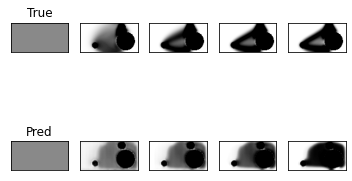

In [75]:
n = 28#np.random.randint(0,len(Data_score)-1)
print(n)
DrawModelIteratins(n)

In [22]:
#n = np.random.randint(0,len(Data_score)-1)
n = np.arange(len(Data_score),dtype='int32')
np.random.shuffle(n)
print(len(n))
for i in range(10):
    DrawModelIteratins(n[i])

TypeError: object of type 'int' has no len()

In [ ]:
#save the model because I'm paranoid
checkpoint_path = r"E:\TopoptGAfileSaves\Models\Model_m6"
model.save_weights(checkpoint_path)

In [ ]:
from PIL import Image
import io

In [ ]:
def plotOverIterations(index,data):
    sequenceToStart = data[index]
    numImages = sequenceToStart.numIterations
    imagesToShow = numImages
    #print(numImages)

    sequenceToStart.dispenceData()

    nelx = 100
    nely = 50
    force,support,filled,x_start,x_optimized,finished = sequenceToStart.dispenceData(1)

    force = np.array([force[0]])
    support = np.array([support[0]])
    filled = np.array([filled[0]])
    ImageToPredict = np.array([sequenceToStart.xPhys_array[:,:,0]])
    PredictedImages = [ImageToPredict]


    start = time()
    for i in range(numImages * 3):
        
        output = model.predict({'x':ImageToPredict,'forces':force,'supports':support,'filled':filled},verbose = 0)
        ImageToPredict = output#[0]
        PredictedImages.append(ImageToPredict)
    end = time()
    print("{} iterations took {:.2f} seconds or about {:.5f} seconds per iteration.".format(numImages,end-start,(end-start)/numImages))
    imagesToJump = 1
    imageArray = []

    for i,image in enumerate(PredictedImages):
        fig,ax = plt.subplots(1,1)
        
        if(i == 0):
            ax.set_title("Iteration: {}".format(i))
        else:
            im1 = np.reshape(PredictedImages[i],(nelx*nely))
            im2 = np.reshape(PredictedImages[i-1],(nelx*nely))
            ax.set_title("Iteration: {}, Change: {:.5f}".format(i,np.linalg.norm(im1-im2,ord=np.inf)))
        ax.imshow(np.reshape(image,(nelx,nely)).T,cmap='gray_r',norm=colors.Normalize(vmin=0,vmax=1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')

        im = Image.open(img_buf)
        imageArray.append(im)

        #plt.show()
    return imageArray

In [ ]:
imagesToSave = 10
rnd = np.arange(imagesToSave,dtype='int32')
np.random.shuffle(rnd)
for i in range(10):
    im_array = plotOverIterations(rnd[i],Data)
    im = im_array[0]
    im_array.pop(0)
    im.save("out{}.gif".format(i),save_all=True,append_images = im_array,optimize=False,loop=0)
    im.close()

<h1>Thoughts</h1>

M6: Looking at the model at work shows progress when loads are grouped up. Failures seem to occur with spaced load conditions and low volfrac.